In [31]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

### Below is just code from other files

Later in the notebook we plot our results from running the algorithms.

In [32]:
def generate_lpn_problem(n, m, error_rate):
    s = np.random.randint(0, 2, n)  # Secret vector
#==========FOR NOW SECRET IS GENERATED WITHIN A PROBLEM INSTANCE=======================================
    A = np.random.randint(0, 2, (m, n))  #binary matrix
    noise = np.random.choice([0, 1], size=m, p=[1 - error_rate, error_rate])  
    b = (A @ s) % 2 
    b = (b + noise) % 2  # Adding noise
    return A, b, s

#=========EXAMPLE INSTANCE==============================================================================
# Parameters for the LPN problem
n = 8 # Number of dimensions
m = 1024  # Number of equations
error_rate = 0.2  # Probability of noise
A, b, s = generate_lpn_problem(n, m, error_rate)

def exponential_lpn_solver(A, b):
    n = A.shape[1]
    m = A.shape[0]
    best_u = None
    min_mismatches = m  #initialized to max

    for candidate in product([0, 1], repeat=n):
        u_candidate = np.array(candidate, dtype=np.uint8)
        b_candidate = np.dot(A, u_candidate) % 2
        
       
        mismatches = np.sum(b_candidate != b)
        #revaluate best_u and min_mismatches
        if mismatches < min_mismatches:
            min_mismatches = mismatches
            best_u = u_candidate
    
    return best_u
def bkw_algo(A, b, bkt_sz):
    rows, cols = A.shape
    bkts = [np.zeros((0, cols), dtype=int) for _ in range(bkt_sz)]
    bkts_b = [np.zeros(0, dtype=int) for _ in range(bkt_sz)]
    idxs = np.random.permutation(rows)#shuffling the inputs
    A = A[idxs]
    b = b[idxs]
    
    #Bucket reduction
    for r in range(rows):
        reduced = False
        for _ in range(bkt_sz):  #randomly reduce using a bucket
            bkt_idx = np.random.randint(0, bkt_sz)  #random bucket index
            if bkts[bkt_idx].shape[0] > 0:  #if bucket is not empty
                vec_idx = np.random.randint(0, bkts[bkt_idx].shape[0])  #use a random vector to zero out
                if A[r, bkt_idx] == 1:
                    # Reduce the vector using random bucket vector
                    A[r] ^= bkts[bkt_idx][vec_idx]
                    b[r] ^= bkts_b[bkt_idx][vec_idx]
            if np.all(A[r][:bkt_idx] == 0):  #successfully reduced? check
                bkts[bkt_idx] = np.vstack([bkts[bkt_idx], A[r]])
                bkts_b[bkt_idx] = np.append(bkts_b[bkt_idx], b[r])
                reduced = True
                break
        if not reduced:
            #not reduced, place into the first bucket
            bkts[0] = np.vstack([bkts[0], A[r]])
            bkts_b[0] = np.append(bkts_b[0], b[r])
    
    #Gaussian elimination on reduced A and b
    red_A = []
    red_b = []
    for c in range(bkt_sz):
        red_A.append(bkts[c])
        red_b.append(bkts_b[c])
    red_A = np.vstack(red_A)
    red_b = np.concatenate(red_b)
    
    # Solve using code found on the internet
    num_cols = red_A.shape[1]
    for r in range(num_cols):
        # Find a pivot row
        pivot = None
        for c in range(r, red_A.shape[0]):
            if red_A[c, r] == 1:
                pivot = c
                break
        if pivot is None:
            continue  # Skip if no pivot found
        # Swap rows
        red_A[[r, pivot]] = red_A[[pivot, r]]
        red_b[[r, pivot]] = red_b[[pivot, r]]
        # Eliminate below
        for c in range(r + 1, red_A.shape[0]):
            if red_A[c, r] == 1:
                red_A[c] ^= red_A[r]
                red_b[c] ^= red_b[r]
    
    #back-substitution
    x = np.zeros(num_cols, dtype=int)
    for r in range(num_cols - 1, -1, -1):
        if red_A[r, r] == 1:
            x[r] = red_b[r]
            for c in range(r + 1, num_cols):
                x[r] ^= red_A[r, c] * x[c]
    return x

#==========IMPLEMENTING A MAJORITY BIT VOTING SYSTEM==========================================================
def majority_vote_bkw(A, b, bucket_size, runs=10):
    m, n = A.shape
    votes = np.zeros((runs, n), dtype=int)  # recovering vectors for votes

    # Run algorithm multiple times
    for i in range(runs):
        recovered_s = bkw_algo(A, b, bucket_size)
        votes[i] = recovered_s

    #majority voting for each bit
    final_s = np.zeros(n, dtype=int)
    for bit in range(n):
        bit_votes = votes[:, bit]
        final_s[bit] = 1 if np.sum(bit_votes) > runs / 2 else 0  #majority rule
    
    return final_s




In [43]:
# For storing results
success_rates_exp = []
success_rates_bkw_majority = []
success_rates_bkw = []
bitwise_accuracy_exp = []
bitwise_accuracy_bkw_majority = []
bitwise_accuracy_bkw = []


In [45]:
# Parameters
n = 4
m_values = range(5, 125, 5)
num_trials = 10
error_rate = 0.2
bucket_size = 4


In [46]:

# Run trials
for m in m_values:
    exp_success_count = 0
    bkw_majority_success_count = 0
    bkw_success_count = 0
    exp_bitwise_correct = 0
    bkw_majority_bitwise_correct = 0
    bkw_bitwise_correct = 0
    total_bits = n * num_trials

    for _ in range(num_trials):
        A, b, s = generate_lpn_problem(n, m, error_rate)

        # Exponential Algorithm
        recovered_s_exp = exponential_lpn_solver(A, b)
        if np.array_equal(recovered_s_exp, s):
            exp_success_count += 1
        exp_bitwise_correct += np.sum(recovered_s_exp == s)

        # BKW with Majority Voting
        recovered_s_bkw_majority = majority_vote_bkw(A, b, bucket_size)
        if np.array_equal(recovered_s_bkw_majority, s):
            bkw_majority_success_count += 1
        bkw_majority_bitwise_correct += np.sum(recovered_s_bkw_majority == s)

        # BKW without Majority Voting
        recovered_s_bkw = bkw_algo(A, b, bucket_size)
        if np.array_equal(recovered_s_bkw, s):
            bkw_success_count += 1
        bkw_bitwise_correct += np.sum(recovered_s_bkw == s)

    # Calculate success rates and bitwise accuracy
    success_rates_exp.append(exp_success_count / num_trials)
    success_rates_bkw_majority.append(bkw_majority_success_count / num_trials)
    success_rates_bkw.append(bkw_success_count / num_trials)

    bitwise_accuracy_exp.append(exp_bitwise_correct / total_bits)
    bitwise_accuracy_bkw_majority.append(bkw_majority_bitwise_correct / total_bits)
    bitwise_accuracy_bkw.append(bkw_bitwise_correct / total_bits)



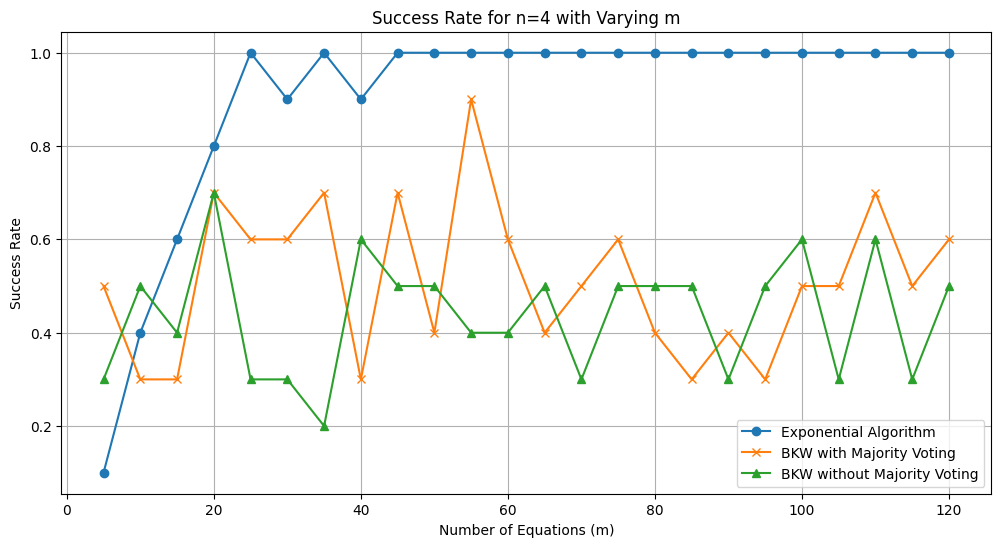

In [47]:
# Plot Success Rate
plt.figure(figsize=(12, 6))
plt.plot(m_values, success_rates_exp, label='Exponential Algorithm', marker='o')
plt.plot(m_values, success_rates_bkw_majority, label='BKW with Majority Voting', marker='x')
plt.plot(m_values, success_rates_bkw, label='BKW without Majority Voting', marker='^')
plt.xlabel('Number of Equations (m)')
plt.ylabel('Success Rate')
plt.title(f'Success Rate for n={n} with Varying m')
plt.legend()
plt.grid(True)
plt.show()

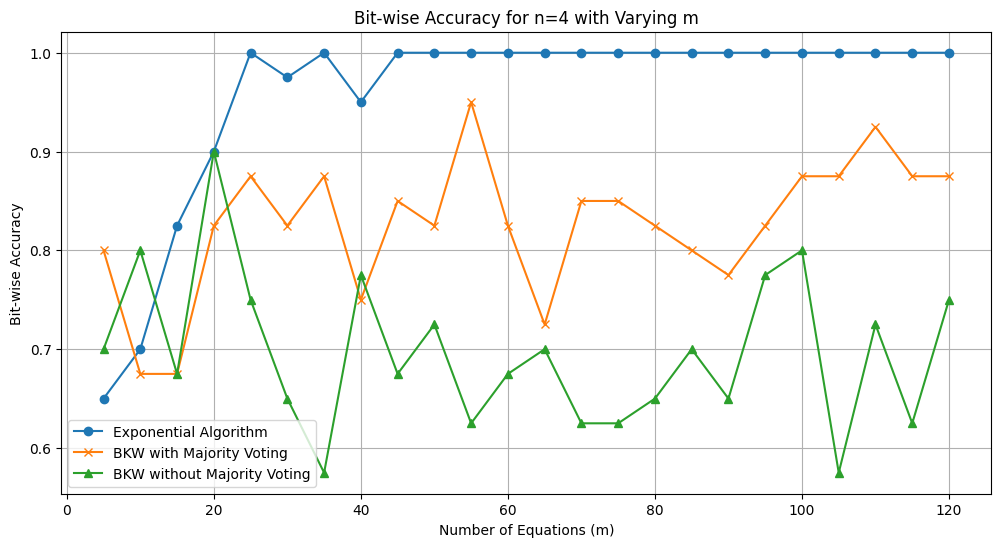

In [48]:

# Plot Bit-wise Accuracy
plt.figure(figsize=(12, 6))
plt.plot(m_values, bitwise_accuracy_exp, label='Exponential Algorithm', marker='o')
plt.plot(m_values, bitwise_accuracy_bkw_majority, label='BKW with Majority Voting', marker='x')
plt.plot(m_values, bitwise_accuracy_bkw, label='BKW without Majority Voting', marker='^')
plt.xlabel('Number of Equations (m)')
plt.ylabel('Bit-wise Accuracy')
plt.title(f'Bit-wise Accuracy for n={n} with Varying m')
plt.legend()
plt.grid(True)
plt.show()